In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('btc.csv')
print(df)

      Unnamed: 0 formatted_date          high           low          open  \
0              0     2019-01-01   3850.913818   3707.231201   3849.216309   
1              1     2019-01-02   3947.981201   3817.409424   3931.048584   
2              2     2019-01-03   3935.685059   3826.222900   3832.040039   
3              3     2019-01-04   3865.934570   3783.853760   3851.973877   
4              4     2019-01-05   3904.903076   3836.900146   3836.519043   
...          ...            ...           ...           ...           ...   
1515        1515     2023-02-24  24103.705078  23007.072266  23200.125000   
1516        1516     2023-02-25  23210.210938  22861.558594  23174.150391   
1517        1517     2023-02-26  23654.367188  23084.220703  23561.451172   
1518        1518     2023-02-27  23857.890625  23205.878906  23521.837891   
1519        1519     2023-02-28  23585.384766  23077.650391  23150.929688   

             close       volume      adjclose  
0      3843.520020   432420

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['close'].rolling(window=ma_3).std()
df.dropna(inplace=True)
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,3608.840820,3558.537109,3575.081299,3576.032471,5004347059,3576.032471,50.303711,3646.814279,3705.745762,3776.614490,50.412745,165.766144
21,21,2019-01-22,3620.746582,3539.721436,3605.557129,3604.577148,5313623556,3604.577148,81.025146,3643.085972,3675.297852,3765.236258,52.717606,169.110917
22,22,2019-01-23,3623.067871,3565.313965,3584.500244,3585.123047,5433755649,3585.123047,57.753906,3633.102574,3643.142613,3748.175002,56.560870,168.308098
23,23,2019-01-24,3616.087402,3569.092773,3607.390381,3600.865479,5262869046,3600.865479,46.994629,3622.002790,3637.566964,3736.942825,53.704202,169.964561
24,24,2019-01-25,3612.927734,3575.597412,3599.715332,3599.765869,5265847539,3599.765869,37.330322,3613.706578,3631.309849,3724.659412,51.693454,170.120767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,24103.705078,23007.072266,23200.125000,23198.126953,26811744928,23198.126953,1096.632812,24224.126395,23553.841936,23260.729632,536.387413,1085.510059
1516,1516,2023-02-25,23210.210938,22861.558594,23174.150391,23175.375000,16100721565,23175.375000,348.652344,24014.711775,23647.020508,23253.278553,625.186896,1085.534512
1517,1517,2023-02-26,23654.367188,23084.220703,23561.451172,23561.212891,16644534842,23561.212891,570.146484,23905.221819,23773.664062,23282.114118,628.353819,1085.276291
1518,1518,2023-02-27,23857.890625,23205.878906,23521.837891,23522.871094,22660763494,23522.871094,652.011719,23718.610770,23896.147600,23318.436105,486.099617,1079.681956


In [4]:
pre_day = 7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','open','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.3)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

450
(1043, 7, 9) (1043, 1) (450, 7, 9) (450, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_close.h5")

Epoch 1/120
40/40 [==============================] - 10s 13ms/step - loss: 0.0193
Epoch 2/120
40/40 [==============================] - 1s 13ms/step - loss: 0.0052
Epoch 3/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0047
Epoch 4/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0043
Epoch 5/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0039
Epoch 6/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0032
Epoch 7/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 8/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0033
Epoch 9/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 10/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0032
Epoch 11/120
40/40 [==============================] - 1s 13ms/step - loss: 0.0030
Epoch 12/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

33/33 [==============================] - 4s 6ms/step
      predict_price  y_train_price  error_price
0       3851.109131    3470.450439   380.658691
1       3815.424805    3448.116943   367.307861
2       3757.341553    3486.181641   271.159912
3       3736.680664    3457.792725   278.887939
4       3738.778564    3487.945312   250.833252
...             ...            ...          ...
1038   57025.519531   57229.828125  -204.308594
1039   57300.808594   56477.816406   822.992188
1040   57190.160156   53598.246094  3591.914062
1041   55580.300781   49200.703125  6379.597656
1042   50373.164062   49368.847656  1004.316406

[1043 rows x 3 columns]


In [7]:

from sklearn.linear_model import ElasticNet
import pickle
elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [8]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_close.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [9]:
predict_price = model.predict(x_test)
print(predict_price)

15/15 [==============================] - 0s 5ms/step
[[0.70727164]
 [0.71797746]
 [0.7265467 ]
 [0.7237665 ]
 [0.7068371 ]
 [0.7029389 ]
 [0.7133748 ]
 [0.7282577 ]
 [0.70864654]
 [0.70475495]
 [0.7126009 ]
 [0.71356696]
 [0.70099247]
 [0.69544107]
 [0.6954941 ]
 [0.6941668 ]
 [0.7078245 ]
 [0.7156618 ]
 [0.73294055]
 [0.7456187 ]
 [0.7522629 ]
 [0.75439286]
 [0.75648046]
 [0.7343358 ]
 [0.7109424 ]
 [0.7042176 ]
 [0.6957459 ]
 [0.69517446]
 [0.6958356 ]
 [0.68547744]
 [0.6832012 ]
 [0.66468126]
 [0.6458146 ]
 [0.63218814]
 [0.61819935]
 [0.6149904 ]
 [0.60668725]
 [0.6106698 ]
 [0.63057286]
 [0.6306033 ]
 [0.6291118 ]
 [0.63355684]
 [0.63553095]
 [0.62657976]
 [0.6225258 ]
 [0.61808366]
 [0.6122059 ]
 [0.5705527 ]
 [0.52969027]
 [0.52367014]
 [0.5179558 ]
 [0.5167795 ]
 [0.52447146]
 [0.5195549 ]
 [0.53421915]
 [0.5447911 ]
 [0.549477  ]
 [0.55276656]
 [0.560195  ]
 [0.54921025]
 [0.5411654 ]
 [0.5769834 ]
 [0.5963404 ]
 [0.61607724]
 [0.6356816 ]
 [0.6475208 ]
 [0.6526978 ]
 [0.65104

In [10]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[48974.867]
 [49661.832]
 [50211.7  ]
 [50033.3  ]
 [48946.984]
 [48696.848]
 [49366.492]
 [50321.49 ]
 [49063.09 ]
 [48813.38 ]
 [49316.832]
 [49378.82 ]
 [48571.95 ]
 [48215.73 ]
 [48219.137]
 [48133.965]
 [49010.344]
 [49513.242]
 [50621.973]
 [51435.496]
 [51861.836]
 [51998.51 ]
 [52132.47 ]
 [50711.504]
 [49210.41 ]
 [48778.9  ]
 [48235.29 ]
 [48198.625]
 [48241.047]
 [47576.39 ]
 [47430.332]
 [46241.957]
 [45031.332]
 [44156.957]
 [43259.336]
 [43053.426]
 [42520.633]
 [42776.184]
 [44053.31 ]
 [44055.266]
 [43959.56 ]
 [44244.785]
 [44371.457]
 [43797.082]
 [43536.953]
 [43251.91 ]
 [42874.754]
 [40201.977]
 [37579.94 ]
 [37193.645]
 [36826.97 ]
 [36751.49 ]
 [37245.062]
 [36929.582]
 [37870.547]
 [38548.92 ]
 [38849.6  ]
 [39060.688]
 [39537.35 ]
 [38832.49 ]
 [38316.27 ]
 [40614.617]
 [41856.703]
 [43123.164]
 [44381.125]
 [45140.812]
 [45473.008]
 [45366.97 ]
 [44838.44 ]
 [44414.38 ]
 [44363.445]
 [44372.355]
 [45287.402]
 [45463.062]
 [43627.926]
 [42115.355]
 [41872.504]

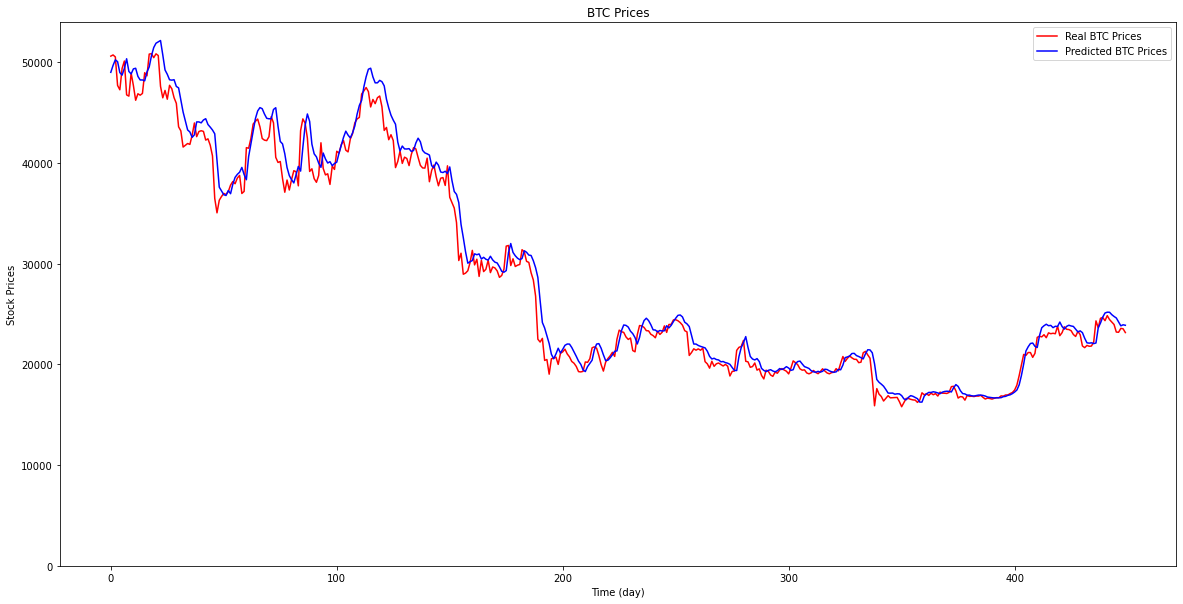

In [11]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real BTC Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted BTC Prices")
plt.title(f"BTC Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [12]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 1035.77
MAPE: 3.52%
MSE: 2227137.53
RMSE: 1492.36
R2: 0.98


In [13]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [14]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))